# Setup, Libraries
Download sample images and a label typeface for this lab, by pasting and running the following command in a new cell. Each line begins with an exclamation point, which tells the kernel to run these bash commands within the notebook cells.

In [1]:
!mkdir sample_images
!wget https://storage.googleapis.com/generativeai-downloads/images/socks.jpg -O sample_images/Socks.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/vegetables.jpg -O sample_images/Vegetables.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/Japanese_Bento.png -O sample_images/Japanese_bento.png -q
!wget https://storage.googleapis.com/generativeai-downloads/images/Cupcakes.jpg -O sample_images/Cupcakes.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/origamis.jpg -O sample_images/Origamis.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/fruits.jpg -O sample_images/Fruits.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/cat.jpg -O sample_images/Cat.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/pumpkins.jpg -O sample_images/Pumpkins.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/breakfast.jpg -O sample_images/Breakfast.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/bookshelf.jpg -O sample_images/Bookshelf.jpg -q
!wget https://storage.googleapis.com/generativeai-downloads/images/spill.jpg -O sample_images/Spill.jpg -q
!sudo apt-get install fonts-noto-cjk  # For Noto Sans CJK JP

mkdir: cannot create directory ‘sample_images’: File exists
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-noto-cjk is already the newest version (1:20201206-cjk+repack1-1).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


In [2]:
from PIL import Image

import io
import os
import requests
from io import BytesIO
import IPython
from IPython.display import Markdown, Video, display

from google import genai
from google.genai import types

from gemini_for_cv_utils import plot_bounding_boxes, parse_json, \
        parse_segmentation_masks, plot_segmentation_masks, generate_point_html, \
        get_url_from_gcs

In [3]:
os.environ

environ{'SHELL': '/bin/bash',
        'CONDA_EXE': '/opt/conda/bin/conda',
        '_CE_M': '',
        'VERTEX_PRODUCT': 'WORKBENCH_INSTANCE',
        'GRPC_FORK_SUPPORT_ENABLED': '0',
        'DL_ANACONDA_HOME': '/opt/conda',
        'FRAMEWORK_FILE_PATH': '/opt/deeplearning/metadata/framework',
        'GOOGLE_CLOUD_PROJECT': 'qwiklabs-gcp-04-27a9e1d9ae22',
        'POST_STARTUP_SCRIPT_PATH': '/opt/c2d/post_start.sh',
        'DL_PATH_DEPS': '/opt/deeplearning/deps',
        'DL_BIN_PATH': '/opt/deeplearning/bin',
        'XML_CATALOG_FILES': 'file:///opt/conda/etc/xml/catalog file:///etc/xml/catalog',
        'KERNEL_LAUNCH_TIMEOUT': '598',
        'BINARIES_PATH': '/opt/deeplearning/binaries',
        'PWD': '/home/jupyter',
        'LOGNAME': 'jupyter',
        'CONDA_PREFIX': '/opt/conda',
        'JPY_SESSION_NAME': '/home/jupyter/gemini_image_understanding.ipynb',
        'TENSORBOARD_PROXY_URL': '/proxy/%PORT%/',
        'GOOGLE_CLOUD_REGION': 'us-central1',
        'PACKAGE_

In [4]:
project_id, = !gcloud config get project
print(project_id)

client = genai.Client(vertexai=True,
                    project=project_id,
                    location="us-central1")

model_name = "gemini-2.5-flash"

qwiklabs-gcp-04-27a9e1d9ae22


In [5]:
# set safety_settings to BLOCK_ONLY_HIGH dangerous content, minimizing the potential number of false alarms for content safety
bounding_box_system_instructions = """
    Return bounding boxes as a JSON array with labels.
    Never return masks or code fencing. Limit to 25 objects.
    If an object is present multiple times, name them according
    to their unique characteristic (colors, size, position,
    unique characteristics, etc.).
    """

# Minimize safety-related errors
safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

# Sample use case

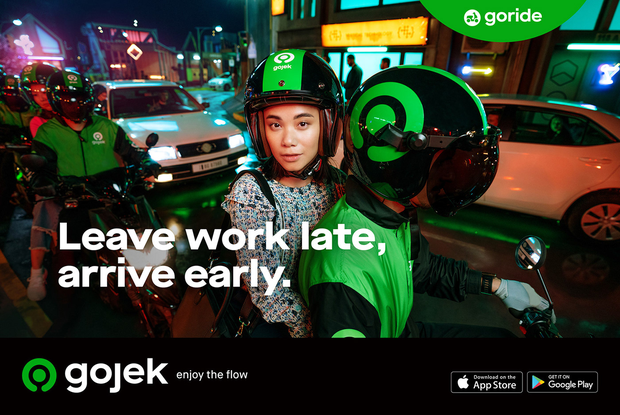

In [11]:
# image
image = "sample_images/gojek-motor-publicad.jpg"
im = Image.open(image)
im.thumbnail([620,620], Image.Resampling.LANCZOS)
im

In [12]:
prompt = (
"Identify and label each distinct item in the image individually. "
"Return specific names such as 'brand logo and text', 'app logo 1', 'app logo 2', "
"'product or service logo and name', 'product or service description', "
"'foregroud', 'background', 'product image', 'extra text', etc., not generic labels like 'items'."
)

# Load and resize image
im = Image.open(BytesIO(open(image, "rb").read()))
im.thumbnail([1024,1024], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
    )
)

# Check output
print(response.text)

```json
[
  {"box_2d": [146, 39, 725, 240], "label": "motorcycle driver on left"},
  {"box_2d": [116, 393, 428, 552], "label": "passenger's helmet"},
  {"box_2d": [155, 550, 509, 804], "label": "driver's helmet"},
  {"box_2d": [187, 137, 461, 407], "label": "white car in middle background"},
  {"box_2d": [223, 755, 638, 999], "label": "white car on right background"},
  {"box_2d": [528, 91, 705, 622], "label": "product or service description text"},
  {"box_2d": [862, 36, 946, 271], "label": "gojek brand logo and text"},
  {"box_2d": [870, 281, 929, 412], "label": "extra text 'enjoy the flow'"},
  {"box_2d": [894, 726, 946, 842], "label": "app store download button"},
  {"box_2d": [894, 850, 945, 966], "label": "google play download button"},
  {"box_2d": [18, 737, 61, 840], "label": "goride logo and text"},
  {"box_2d": [116, 360, 814, 563], "label": "passenger"},
  {"box_2d": [159, 477, 814, 888], "label": "motorcycle driver on right"},
  {"box_2d": [146, 75, 282, 153], "label": "hel

(1024, 686)


/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/var/tmp/tmpa9_iz6qx.PNG'


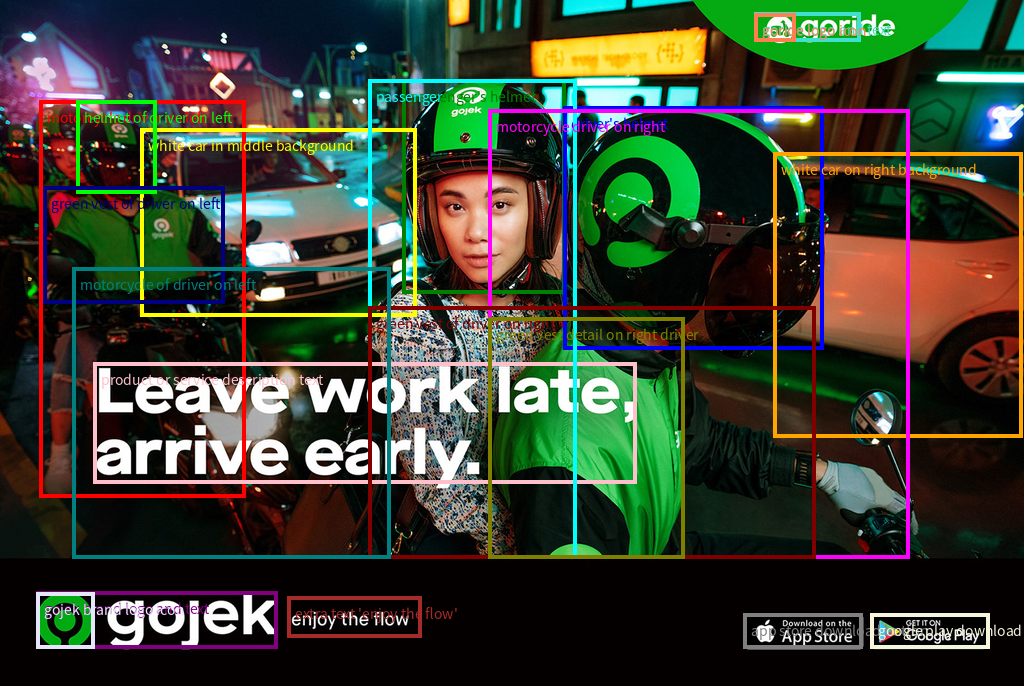

In [13]:
plot_bounding_boxes(im, response.text)
im